[PHOENIX model ftp address](ftp://phoenix.astro.physik.uni-goettingen.de//v1.0/SpecIntFITS/PHOENIX-ACES-AGSS-COND-SPECINT-2011/Z-0.0/)

[Some results on alkali metals in hot Jupiters](http://www.exoclimes.com/news/recent-results/a-survey-of-alkali-line-absorption-in-exoplanetary-atmospheres/)

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import batman

In [25]:
from astropy.utils.data import download_file

wavelength_url = ('ftp://phoenix.astro.physik.uni-goettingen.de/v2.0/HiResFITS/'
                  'WAVE_PHOENIX-ACES-AGSS-COND-2011.fits')
wavelength_path = download_file(wavelength_url, cache=True, timeout=30)
wavelengths_vacuum = fits.getdata(wavelength_path)

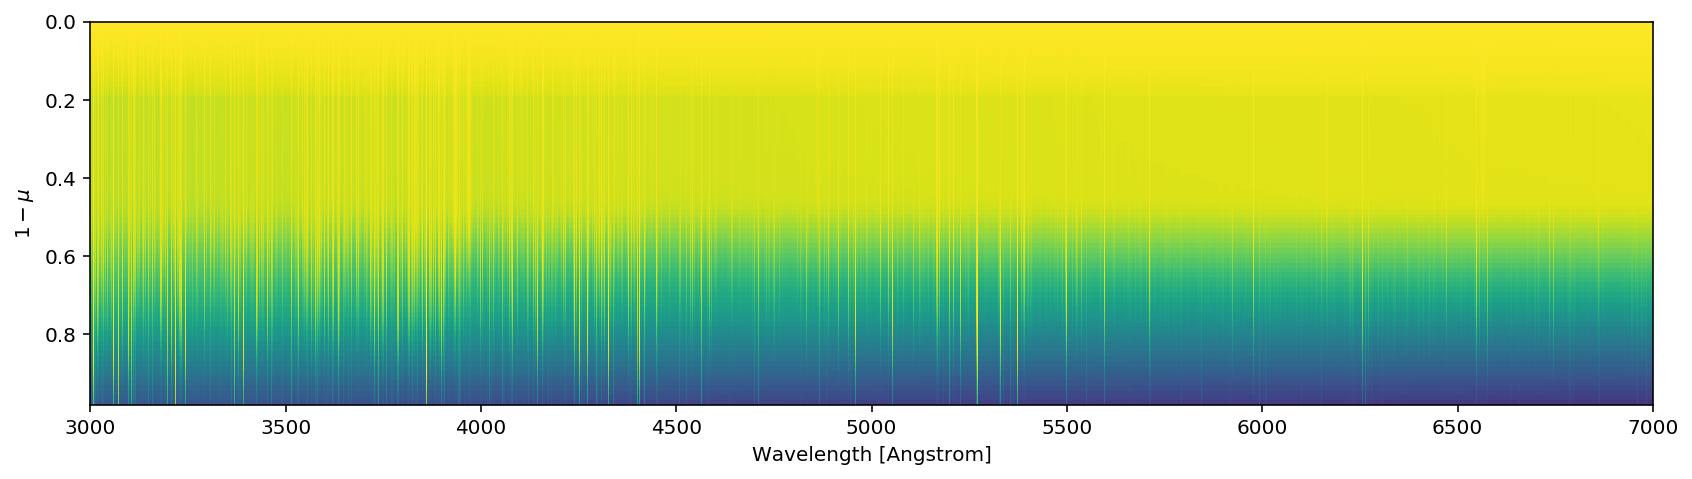

In [218]:
from astropy.io import fits

mu = fits.open("data/lte04800-4.50-0.0.PHOENIX-ACES-AGSS-COND-SPECINT-2011.fits")[1].data
mu_vs_lam = fits.getdata("data/lte05800-4.50-0.0.PHOENIX-ACES-AGSS-COND-SPECINT-2011.fits")
mu_vs_lam /= mu_vs_lam.max(axis=0)

header = fits.getheader("data/lte05800-4.50-0.0.PHOENIX-ACES-AGSS-COND-SPECINT-2011.fits")

wavelengths = header['CRVAL1'] + np.arange(0, mu_vs_lam.shape[1]) * header['CDELT1']

one_minus_mu = 1 - mu
extent = [wavelengths.min(), wavelengths.max(), 
          one_minus_mu.max(), one_minus_mu.min()]
fig, ax = plt.subplots(figsize=(14, 10))
ax.imshow(np.log(mu_vs_lam), extent=extent, origin='lower')
ax.set_xlim([3000, 7000])
ax.set_aspect(1000)
ax.set(xlabel='Wavelength [Angstrom]', ylabel='$1 - \mu$');

In [219]:
mu_vs_lam.shape

(78, 25500)

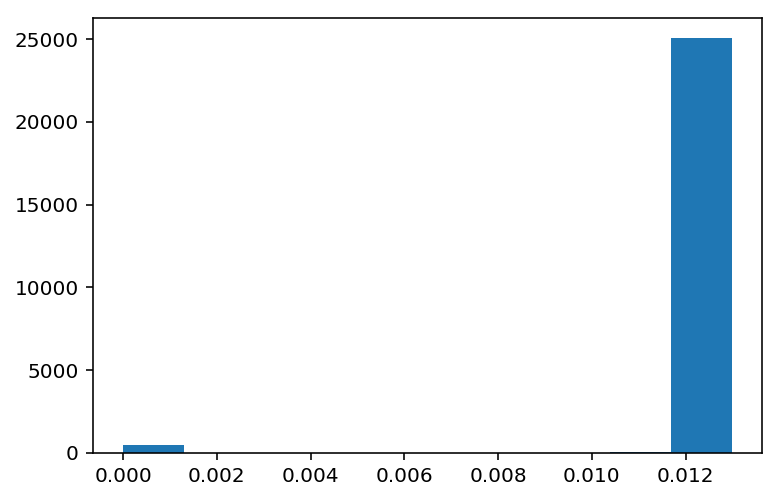

In [220]:
plt.hist(np.mean(np.diff(mu_vs_lam, axis=0), axis=0));

In [319]:
na_D = [5896, 5890]
ca_HK = [3968, 3934]
ref_lambda = 5010
fe_E = 5270
wl_names = ['continuum', 'Na D1', 'Na D2', 'Ca H', 'Ca K']#, 'Fe E']
test_wavelengths = [ref_lambda, na_D[0], na_D[1], ca_HK[0], ca_HK[1]]#, fe_E]
index_ref = np.argmin(np.abs(wavelengths - ref_lambda))
index_d1 = np.argmin(np.abs(wavelengths - na_d[0]))
index_d2 = np.argmin(np.abs(wavelengths - na_d[1]))

In [222]:
def wavelength_to_quadratic(wavelength):
    mu_lower_limit = 0.05
    
    limit_mu = mu > mu_lower_limit
    
    quad_params = np.polyfit(mu[limit_mu], mu_vs_lam[limit_mu, ind], 2)
    return quad_params[::-1]

In [259]:
from scipy.optimize import fmin_powell, fmin_slsqp, fmin_l_bfgs_b

mu_lower_limit = 0.06

In [277]:
def nonlinear(p, mu):
    c_1, c_2, c_3, c_4 = p
    return (1 - c_1*(1 - mu**0.5) - c_2 * (1-mu) - 
            c_3 * (1 - mu**1.5) - c_4 * (1 - mu**2))

def chi2_nl(p, mu, wl):
    limit_mu = mu > mu_lower_limit
    ind = np.argmin(np.abs(wavelengths - wl))
    intensity = mu_vs_lam[limit_mu, ind]
    return np.sum((nonlinear(p, mu[limit_mu]) - intensity)**2 / 0.01**2)

def wavelength_to_nonlinear(wavelength):
    return fmin_slsqp(chi2_nl, [0.5, -0.1, 0.1, -0.1], 
                      args=(mu, wavelength), disp=0)

In [278]:
def logarithmic(p, mu):
    c_1, c_2 = p
    return (1 - c_1*(1-mu) - c_2 * mu * np.log(mu))

def chi2_log(p, mu, wl):
    limit_mu = mu > mu_lower_limit
    ind = np.argmin(np.abs(wavelengths - wl))
    intensity = mu_vs_lam[limit_mu, ind]
    return np.sum((logarithmic(p, mu[limit_mu]) - intensity)**2 /0.01**2)

def wavelength_to_log(wavelength):
    return fmin_l_bfgs_b(chi2_log, [1, 1], args=(mu, wavelength), 
                         approx_grad=True, bounds=[[-1, 2], [-1, 2]], disp=0)[0]

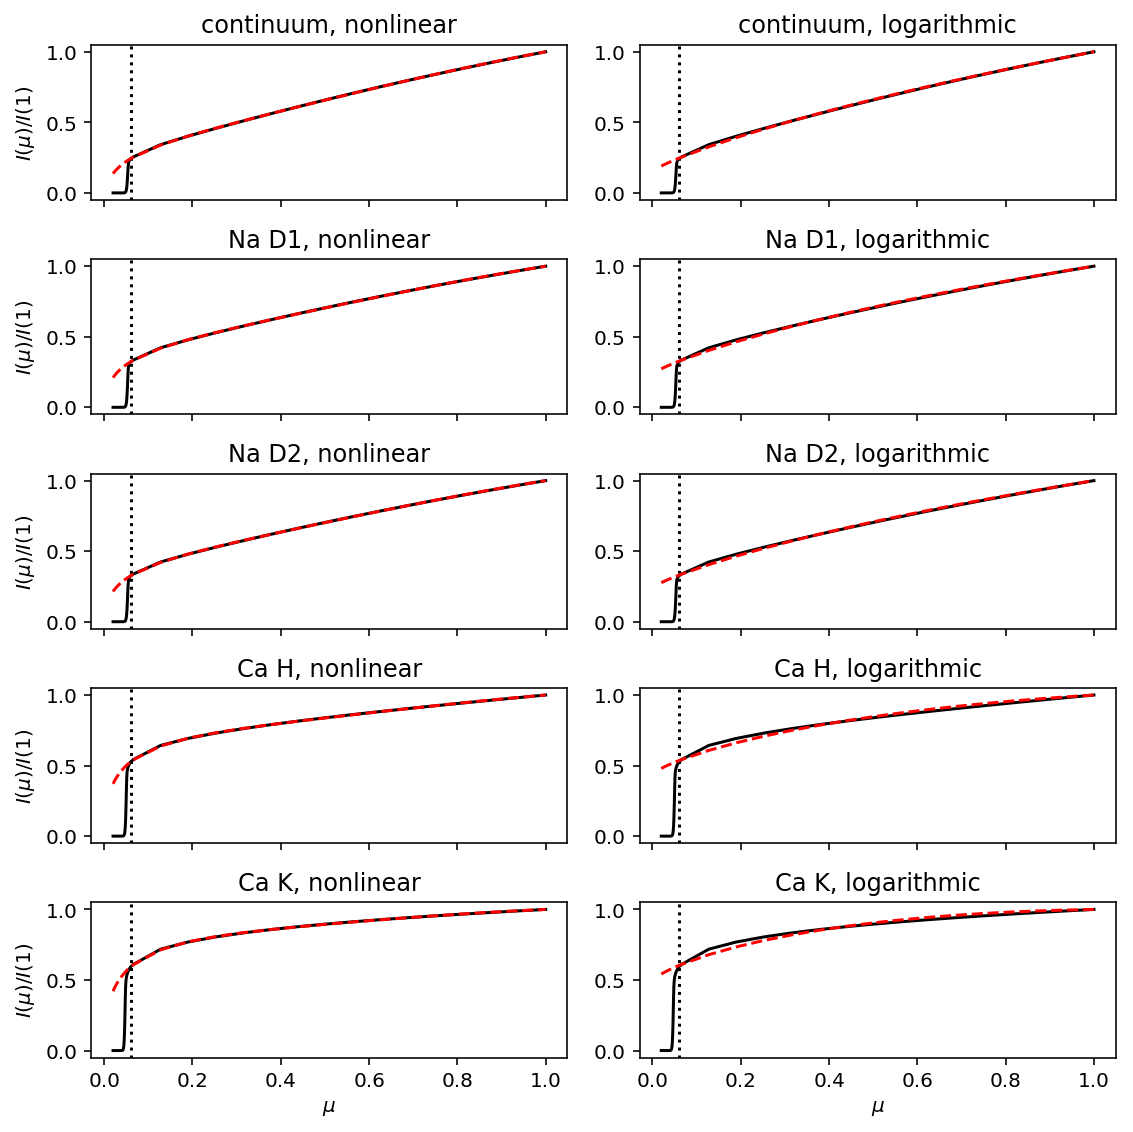

In [327]:
fig, ax = plt.subplots(len(test_wavelengths), 2, figsize=(8, 8), sharex=True)

for i, wl, label in zip(range(len(test_wavelengths)), test_wavelengths, wl_names):
    ind = np.argmin(np.abs(wavelengths - wl))
    
    for j in range(2):
        ax[i, j].plot(mu, mu_vs_lam[:, ind], 'k')
        ax[i, j].axvline(mu_lower_limit, ls=':', color='k')
    
    u_nl = wavelength_to_nonlinear(wl)
    ax[i, 0].plot(mu, nonlinear(u_nl, mu), 'r--')
    u_log = wavelength_to_log(wl)
    ax[i, 1].plot(mu, logarithmic(u_log, mu), 'r--')

    ax[i, 0].set_ylabel('$I(\mu)/I(1)$')
    
    ax[i, 0].set_title(label + ', nonlinear')
    ax[i, 1].set_title(label + ', logarithmic')
for j in range(2):
    ax[-1, j].set_xlabel('$\mu$')
#ax[-1, 0].set(xlabel='$\mu$', ylabel='$I(\mu)/I(1)$')
fig.tight_layout()

In [328]:
from astropy.constants import R_jup, R_sun

def hd189_wavelength_nl(wavelength):
    hd189_params = batman.TransitParams()
    hd189_params.per = 2.21857567
    hd189_params.t0 = 2454279.436714
    hd189_params.inc = 85.7100
    hd189_params.a = 8.84
    hd189_params.rp = float((1.138 * R_jup)/(0.805 * R_sun))
    hd189_params.limb_dark = 'nonlinear'
    hd189_params.u = wavelength_to_nonlinear(wavelength)
    hd189_params.ecc = 0
    hd189_params.w = 90
    return hd189_params

def wavelength_to_transit(times, wavelength):
    params = hd189_wavelength(wavelength)
    model = batman.TransitModel(params, times)
    f = model.light_curve(params)
    return f

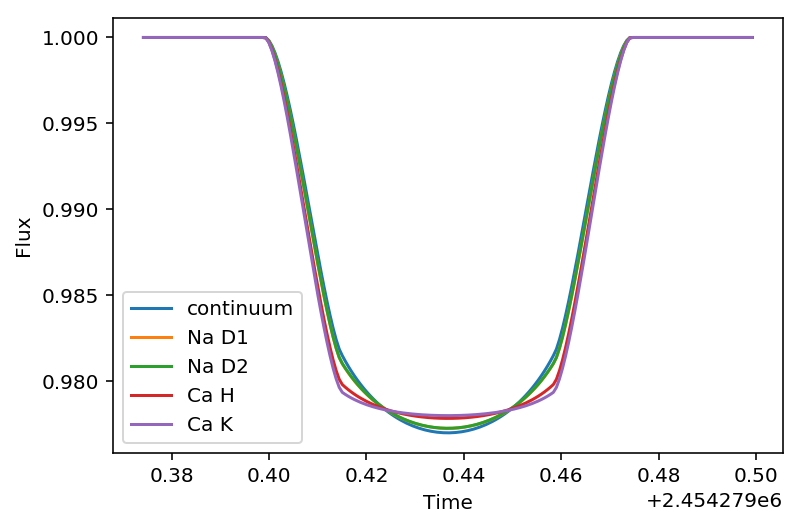

In [329]:
import astropy.units as u

times = params.t0 + np.linspace(-1.5/24, 1.5/24, 200)

for i, wl, label in zip(range(len(test_wavelengths)), test_wavelengths, wl_names):
    f = wavelength_to_transit(times, wl)
    plt.plot(times, f, label=label)
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend()

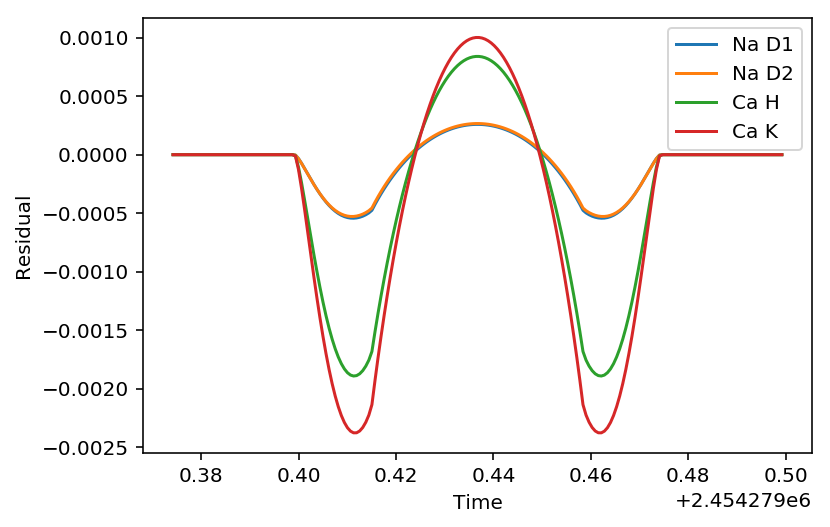

In [330]:
f_continuum = wavelength_to_transit(times, ref_lambda)

for i, wl, label in zip(range(len(test_wavelengths)-1), test_wavelengths[1:], wl_names[1:]):
    f = wavelength_to_transit(times, wl)
    plt.plot(times, f - f_continuum, label=label)
plt.xlabel('Time')
plt.ylabel('Residual')
plt.legend();